# Tweeter Sentiment Analysis

## Reference

https://arxiv.org/abs/1408.5882

https://github.com/cmasch/cnn-text-classification

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import os
import re
import string
import keras
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
plt.style.use('seaborn')

## Parameters Assignment

In [23]:
MAX_NUM_WORDS     = 15000
EMBEDDING_DIM     = 300
MAX_SEQ_LENGTH    = 500
USE_GLOVE         = True
KERNEL_SIZES      = [3,4,5]
FEATURE_MAPS      = [200,200,200]
USE_CHAR          = False
ALPHABET          = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
ALPHABET_SIZE     = len(ALPHABET)
CHAR_MAX_LENGTH   = 1600
CHAR_KERNEL_SIZES = [5,10,20]
CHAR_FEATURE_MAPS = [300,300,300]

DROPOUT_RATE      = 0.4
HIDDEN_UNITS      = 200
NB_CLASSES        = 2

BATCH_SIZE        = 100
NB_EPOCHS         = 5
RUNS              = 1
VAL_SIZE          = 0.2

## Pre-process the Data

In [24]:
def clean_doc(doc):
    """
    Cleaning a document by several methods:
        - Lowercase
        - Removing whitespaces
        - Removing numbers
        - Removing stopwords
        - Removing punctuations
        - Removing short words
    """
    # stop_words = set(stopwords.words('english'))

    # Lowercase
    doc = doc.lower()
    # Remove numbers
    doc = re.sub(r"[0-9]+", "", doc)
    # Split in tokens
    tokens = doc.split()
    # Remove Stopwords
    tokens = [w for w in tokens if not w in stop_words]
    # Remove punctuation
    tokens = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokens]
    # Tokens with less then two characters will be ignored
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)


def read_files(file_name):
    labels = []
    # Read in all files in directory
    data = pd.read_csv(file_name)
    doc = data['Text'].tolist()
    labels = data['Label'].tolist()
    X_train, X_test, y_train, y_test = train_test_split(doc, labels, test_size = 0.33, random_state = 42)
    return X_train, X_test, y_train, y_test

In [25]:
X_train, X_test, y_train, y_test = read_files('tweets_data.csv')

y_train = keras.utils.to_categorical(y_train)
print('Training samples: %i' % len(X_train))

Training samples: 5782


## Preprocessing for word-based model

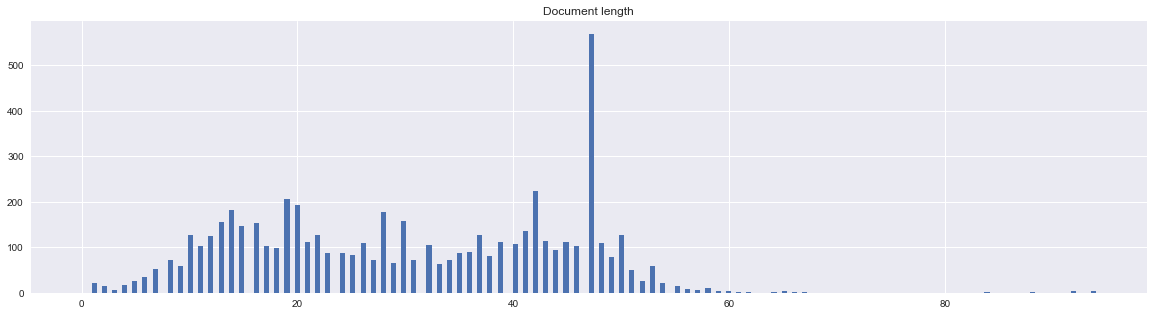

Text informations:
max length: 94 / min length: 1 / mean length: 30 / limit length: 500
vacobulary size: 16456 / limit: 15000


In [26]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)

word_index = tokenizer.word_index

result = [len(x.split()) for x in X_train]

# Plot histogram
plt.figure(figsize=(20,5))
plt.title('Document length')
plt.hist(result, 200, density=False, range=(0,np.max(result)))
plt.show()


print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))
print('vacobulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
word_data = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')


## Embedding

In [27]:
def create_glove_embeddings():
    print('Pretrained embeddings GloVe is loading...')

    embeddings_index = {}
    f = open('glove.6B.%id.txt' % EMBEDDING_DIM)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors in GloVe embedding' % len(embeddings_index))

    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return keras.layers.Embedding(
        input_dim=MAX_NUM_WORDS,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQ_LENGTH,
        weights=[embedding_matrix],
        trainable=True,
        name="word_embedding"
    )


## Training

In [28]:
from cnn_model import CNN

histories = []

for i in range(RUNS):
    print('Running iteration %i/%i' % (i + 1, RUNS))
    random_state = np.random.randint(1000)

    X_train, X_val, y_train, y_val = train_test_split(word_data, y_train, test_size=VAL_SIZE, random_state=random_state)

    
    emb_layer = None
    if USE_GLOVE:
        emb_layer = create_glove_embeddings()

    model = CNN(
        embedding_layer=emb_layer,
        num_words=MAX_NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        kernel_sizes=KERNEL_SIZES,
        feature_maps=FEATURE_MAPS,
        max_seq_length=MAX_SEQ_LENGTH,
        use_char=USE_CHAR,
        char_max_length=CHAR_MAX_LENGTH,
        alphabet_size=ALPHABET_SIZE,
        char_kernel_sizes=CHAR_KERNEL_SIZES,
        char_feature_maps=CHAR_FEATURE_MAPS,
        dropout_rate=DROPOUT_RATE,
        hidden_units=HIDDEN_UNITS,
        nb_classes=NB_CLASSES
    ).build_model()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(),
        metrics=['accuracy']
    )

    # model.summary()

    history = model.fit(
        X_train, y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=[
            keras.callbacks.ModelCheckpoint(
                'model-%i.h5' % (i + 1), monitor='val_loss', verbose=1, save_best_only=True, mode='min'
            ),
            # keras.callbacks.TensorBoard(log_dir='./logs/temp', write_graph=True)
        ]
    )
    print()
    histories.append(history.history)

Running iteration 1/1
Pretrained embeddings GloVe is loading...
Found 400000 word vectors in GloVe embedding
Train on 4625 samples, validate on 1157 samples
Epoch 1/5
4625/4625 [==============================] - 264s 57ms/step - loss: 0.0787 - acc: 0.9844 - val_loss: 0.0219 - val_acc: 0.9965

Epoch 00001: val_loss improved from inf to 0.02192, saving model to model-1.h5
Epoch 2/5
4625/4625 [==============================] - 256s 55ms/step - loss: 0.0366 - acc: 0.9937 - val_loss: 0.0267 - val_acc: 0.9965

Epoch 00002: val_loss did not improve from 0.02192
Epoch 3/5
4625/4625 [==============================] - 252s 55ms/step - loss: 0.0343 - acc: 0.9937 - val_loss: 0.0265 - val_acc: 0.9965

Epoch 00003: val_loss did not improve from 0.02192
Epoch 4/5
4625/4625 [==============================] - 264s 57ms/step - loss: 0.0322 - acc: 0.9937 - val_loss: 0.0265 - val_acc: 0.9965

Epoch 00004: val_loss did not improve from 0.02192
Epoch 5/5
4625/4625 [==============================] - 258s 56m

## Evaluation

In [29]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)


print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))


Training: 	0.0787 loss / 0.9844 acc
Validation: 	0.0219 loss / 0.9965 acc


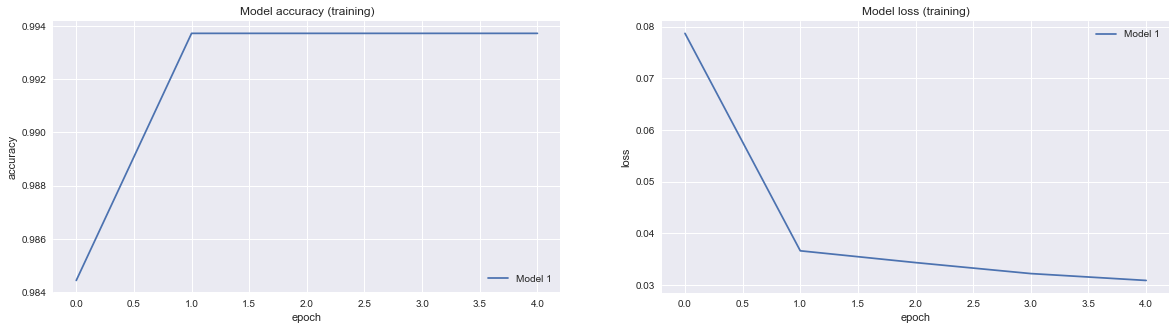

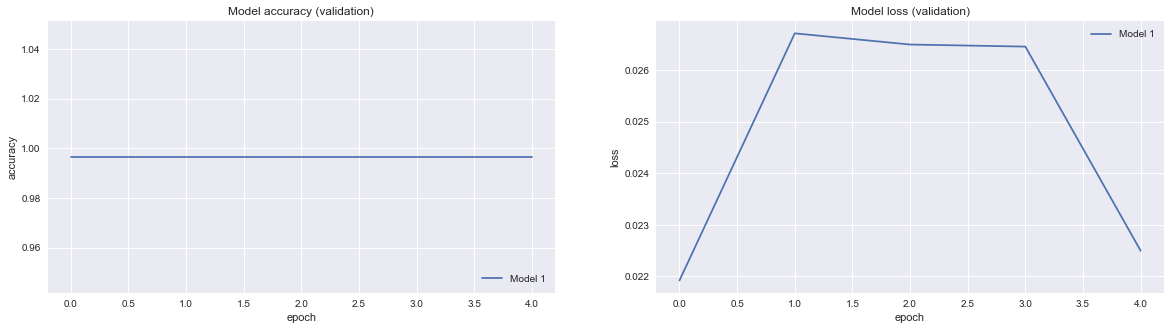

In [30]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()


plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')

## Test

In [31]:
y_test = keras.utils.to_categorical(y_test)
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_test)
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test_word = keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=MAX_SEQ_LENGTH, padding='post')


In [32]:
test_loss = []
test_accs = []

for i in range(0, RUNS):
    cnn_ = keras.models.load_model("model-%i.h5" % (i + 1))
    score = cnn_.evaluate(X_test_word, y_test, verbose=1)
    test_loss.append(score[0])
    test_accs.append(score[1])

    print('Running test with model %i: %0.4f loss / %0.4f acc' % (i + 1, score[0], score[1]))

print('\nAverage loss / accuracy on testset: %0.4f loss / %0.4f acc' % (np.mean(test_loss),
                                                                        np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss), np.std(test_accs)))


2848/2848 [==============================] - 33s 11ms/step
Running test with model 1: 0.0330 loss / 0.9947 acc

Average loss / accuracy on testset: 0.0330 loss / 0.9947 acc
Standard deviation: (+-0.0000) loss / (+-0.0000) acc
